In [1]:
import numpy as np
import scipy.sparse.linalg as splinalg
from scipy import interpolate
import matplotlib.pyplot as plt

# Optional
import cmasher as cmr
from tqdm import tqdm

Solution Strategy:

* Start with zero velocity everywhere: u = [0, 0]

1. Add forces

    w₁ = u + Δt f

2. Convect by self-advection (set the value at the current
   location to be the value at the position backtraced
   on the streamline.) -> unconditionally stable

    w₂ = w₁(p(x, −Δt))

3. Diffuse implicitly (Solve a linear system matrix-free
   by Conjugate Gradient) -> unconditionally stable

    (I − ν Δt ∇²)w₃ = w₂

4. Compute a pressure correction (Solve a linear system
    matrix-free by Conjugate gradient)

    ∇² p = ∇ ⋅ w₃

5. Correct velocities to be incompressible

    w₄ = w₃ − ∇p

6. Advance to next time step

    u = w₄ 

In [2]:
# constants 

DOMAIN_SIZE = 1.0
N_POINTS = 41
N_TIME_STEPS = 100
TIME_STEP_LENGTH = 0.1
KINEMATIC_VISCOSITY = 0.0001
MAX_ITER_CG = None

In [3]:
element_length = DOMAIN_SIZE / (N_POINTS - 1)
scalar_shape   = (N_POINTS, N_POINTS)
scalar_dof     = N_POINTS**2
vector_shape   = (N_POINTS, N_POINTS, 2)
vector_dof     = N_POINTS**2 * 2

x = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)
y = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)

In [4]:
# attach (x,y) coordinates on mesh of (N,N) -> shape of vector field (N,N,2)
X, Y = np.meshgrid(x, y, indexing="ij")
coordinates = np.concatenate(
        (
            X[..., np.newaxis],
            Y[..., np.newaxis],
        ),
        axis=-1,          
    )

coordinates.shape

(41, 41, 2)

In [5]:
X

array([[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.025, 0.025, 0.025, ..., 0.025, 0.025, 0.025],
       [0.05 , 0.05 , 0.05 , ..., 0.05 , 0.05 , 0.05 ],
       ...,
       [0.95 , 0.95 , 0.95 , ..., 0.95 , 0.95 , 0.95 ],
       [0.975, 0.975, 0.975, ..., 0.975, 0.975, 0.975],
       [1.   , 1.   , 1.   , ..., 1.   , 1.   , 1.   ]])

In [6]:
Y

array([[0.   , 0.025, 0.05 , ..., 0.95 , 0.975, 1.   ],
       [0.   , 0.025, 0.05 , ..., 0.95 , 0.975, 1.   ],
       [0.   , 0.025, 0.05 , ..., 0.95 , 0.975, 1.   ],
       ...,
       [0.   , 0.025, 0.05 , ..., 0.95 , 0.975, 1.   ],
       [0.   , 0.025, 0.05 , ..., 0.95 , 0.975, 1.   ],
       [0.   , 0.025, 0.05 , ..., 0.95 , 0.975, 1.   ]])

In [7]:
# select (x,y) coordinates at mesh point (1,1)
coordinates[1][1]

array([0.025, 0.025])

In [8]:
# time-> scaler, point -> (x,y) coordinate points
# this function applies a time decaying force @ (x,y) 

def forcing_function(time, point):
    time_decay = np.maximum(                   # force decays to zero as t-> large
        2.0 - 0.5 * time,
        0.0,
    )

    forced_value = (
        time_decay                             # force strength (this is a scaler) @ t                   
        *
        np.where(                              # select specific region (x,y) to apply force 
            (
                (point[0] > 0.4)
                &
                (point[0] < 0.6)
                &
                (point[1] > 0.1)
                &
                (point[1] < 0.3)
            ),
            np.array([0.0, 1.0]),              # apply the force along y on the selected region 
            np.array([0.0, 0.0]),              # the x force is zero 
        )
    )

    return forced_value                        # return the force @ point (Fx,Fy)

In [9]:
# vectorize the forcing function 
forcing_function_vectorized = np.vectorize(
    pyfunc=forcing_function,
    signature="(),(d)->(d)",                   
)

In [10]:
# partial derivative of field (N,N) along x direction 
def partial_derivative_x(field):
    diff = np.zeros_like(field)

    diff[1:-1, 1:-1] = (
        (
            field[2:  , 1:-1]
            -
            field[0:-2, 1:-1]
        ) / (
            2 * element_length
        )
    )

    return diff

In [11]:
# partial derivative of field (N,N) along y direction 
def partial_derivative_y(field):
        diff = np.zeros_like(field)

        diff[1:-1, 1:-1] = (
            (
                field[1:-1, 2:  ]
                -
                field[1:-1, 0:-2]
            ) / (
                2 * element_length
            )
        )

        return diff

In [12]:
# laplacian (del^2) of a field (N,N)
def laplace(field):
        diff = np.zeros_like(field)

        diff[1:-1, 1:-1] = (
            (
                field[0:-2, 1:-1]
                +
                field[1:-1, 0:-2]
                - 4 *
                field[1:-1, 1:-1]
                +
                field[2:  , 1:-1]
                +
                field[1:-1, 2:  ]
            ) / (
                element_length**2
            )
        )

        return diff

In [13]:
# apply divergence (del.dot) on a vector field (N,N,2)
def divergence(vector_field):
    divergence_applied = (
        partial_derivative_x(vector_field[..., 0])
        +
        partial_derivative_y(vector_field[..., 1])
    )

    return divergence_applied

In [14]:
# apply the gradient (del) on field (N,N)
def gradient(field):
    gradient_applied = np.concatenate(
        (
            partial_derivative_x(field)[..., np.newaxis],
            partial_derivative_y(field)[..., np.newaxis],
        ),
        axis=-1,
    )

    return gradient_applied

In [15]:
# apply curl (del cross) on vector field (N,N,2), Note: this only return the z component of curl 
def curl_2d(vector_field):
    curl_applied = (
        partial_derivative_x(vector_field[..., 1])
        -
        partial_derivative_y(vector_field[..., 0])
    )

    return curl_applied

In [16]:
# set the value at the current location to be the value at the position backtraced on the streamline.
# note the field below is also a vector field (its a 2D vector attached to the coordinate mesh)
def advect(field, vector_field):
    backtraced_positions = np.clip(                 # go backward in coordinates along the field 
        (
            coordinates
            -
            TIME_STEP_LENGTH
            *
            vector_field
        ),  
        0.0,                                        # implement non-negative backtraced points 
        DOMAIN_SIZE,                                # make-sure the backward steps are not going beyond the domain 
    )

    advected_field = interpolate.interpn(
        points=(x, y),                              # points define the grid 
        values=field,                               # data on the grid 
        xi=backtraced_positions,                    # coordintes to sample grided data 
    )

    return advected_field

In [17]:
# This function impliment (I − ν Δt ∇²)w, where w is vector field (flattened to solve for linear system of equation later)
def diffusion_operator(vector_field_flattened):
    vector_field = vector_field_flattened.reshape(vector_shape)

    diffusion_applied = (
        vector_field
        -
        KINEMATIC_VISCOSITY
        *
        TIME_STEP_LENGTH
        *
        laplace(vector_field)
    )

    return diffusion_applied.flatten()

In [18]:
# this function computed the: ∇² p, we need flattened field to solve linear system of equations 
def poisson_operator(field_flattened):
    field = field_flattened.reshape(scalar_shape)

    poisson_applied = laplace(field)

    return poisson_applied.flatten()

  0%|          | 0/100 [00:00<?, ?it/s]

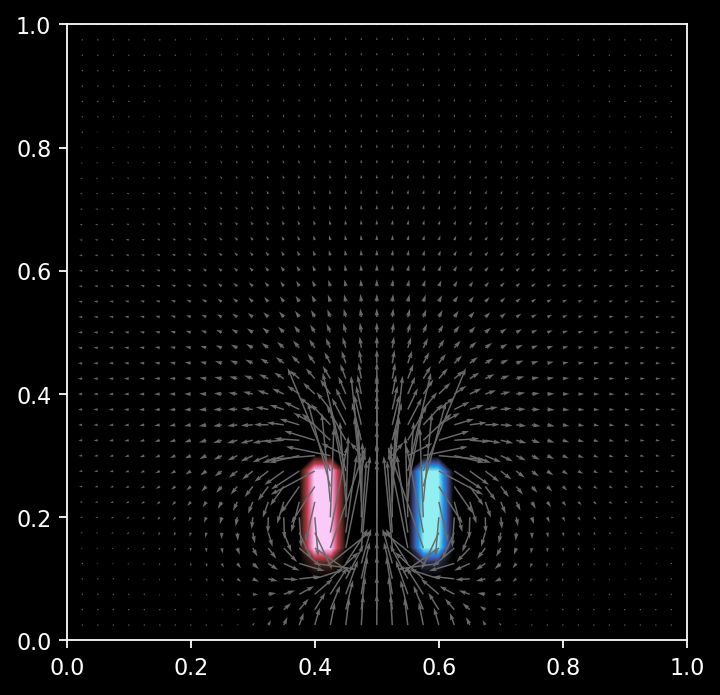

<Figure size 640x480 with 0 Axes>

 19%|█▉        | 19/100 [00:01<00:06, 12.31it/s]

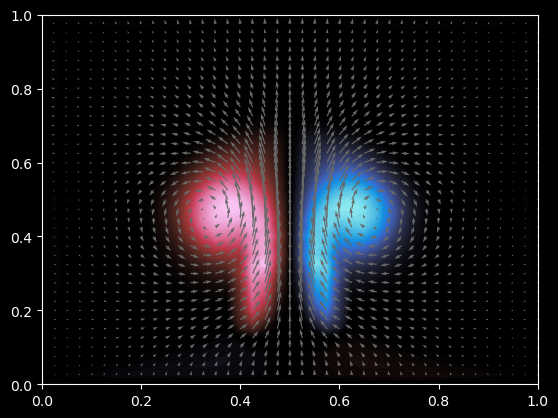

<Figure size 640x480 with 0 Axes>

 40%|████      | 40/100 [00:04<00:04, 14.35it/s]

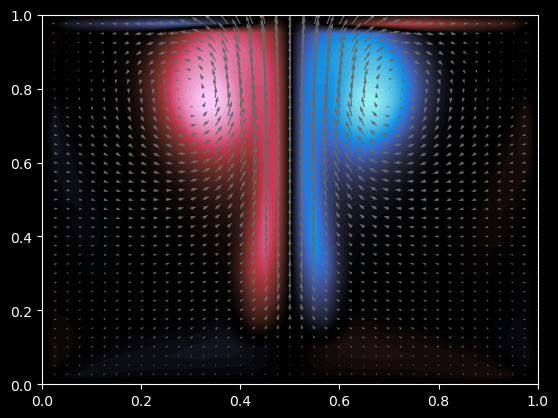

<Figure size 640x480 with 0 Axes>

 60%|██████    | 60/100 [00:07<00:03, 11.91it/s]

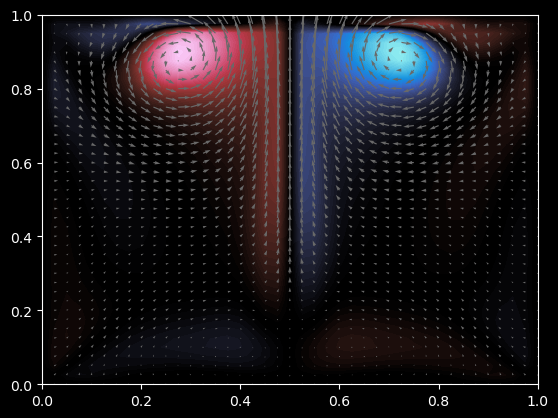

<Figure size 640x480 with 0 Axes>

 80%|████████  | 80/100 [00:10<00:01, 12.67it/s]

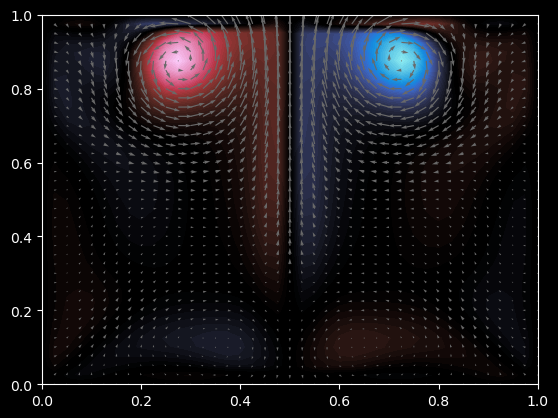

<Figure size 640x480 with 0 Axes>

100%|██████████| 100/100 [00:13<00:00,  7.44it/s]


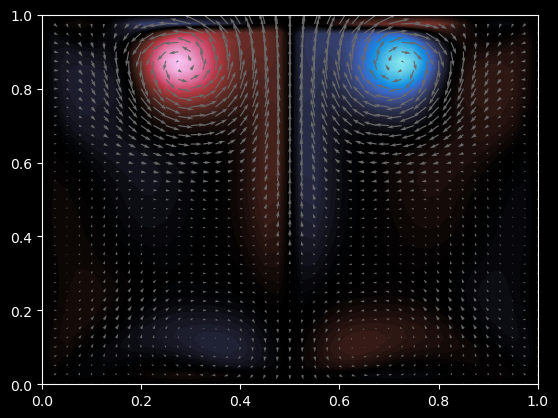

In [22]:
time_current = 0.0
velocities_prev = np.zeros(vector_shape)

plt.style.use("dark_background")
plt.figure(figsize=(5, 5), dpi=160)

for i in tqdm(range(N_TIME_STEPS)):
        time_current += TIME_STEP_LENGTH
        # apply the force (on a specific region of coordinated grid)
        forces = forcing_function_vectorized(
            time_current,
            coordinates,
        )

        # (1) The velocity after the force is applied 
        velocities_forces_applied = (
            velocities_prev
            +
            TIME_STEP_LENGTH
            *
            forces
        )

        # (2) Nonlinear convection (=self-advection)
        velocities_advected = advect(
            field=velocities_forces_applied,
            vector_field=velocities_forces_applied,
        )

        # (3) Diffuse
        velocities_diffused = splinalg.cg(
            A=splinalg.LinearOperator(
                shape=(vector_dof, vector_dof),
                matvec=diffusion_operator,
            ),
            b=velocities_advected.flatten(),
            maxiter=MAX_ITER_CG,
        )[0].reshape(vector_shape)

        # (4.1) Compute a pressure correction
        pressure = splinalg.cg(
            A=splinalg.LinearOperator(
                shape=(scalar_dof, scalar_dof),
                matvec=poisson_operator,
            ),
            b=divergence(velocities_diffused).flatten(),
            maxiter=MAX_ITER_CG,
        )[0].reshape(scalar_shape)

        # (4.2) Correct the velocities to be incompressible
        velocities_projected = (
            velocities_diffused
            -
            gradient(pressure)
        )

        # Advance to next time step
        velocities_prev = velocities_projected

        # Plot
        curl = curl_2d(velocities_projected)
        plt.contourf(
            X,
            Y,
            curl,
            cmap=cmr.redshift,
            levels=100,
        )
        plt.quiver(
            X, 
            Y,
            velocities_projected[..., 0],
            velocities_projected[..., 1],
            color="dimgray",
        )
        
        if i%20 ==0:
            plt.draw()
            plt.pause(0.0001)
            plt.clf()
            plt.show()


        